In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import dill

In [3]:
with open('/kaggle/input/headboxes-4-cams/headboxes_c1.dill', 'rb') as f:
    headboxdata = dill.load(f)
cam0data = headboxdata['cam0']
cam1data = headboxdata['cam1']
cam2data = headboxdata['cam2']
cam3data = headboxdata['cam3']
homographies = {
    0: np.array([
        [-1.6688907435, -6.9502305710, 940.69592392565],
        [1.1984806153, -10.7495778320, 868.29873467315],
        [0.0004069210, -0.0209324057, 0.42949125235]
    ]),
    1: np.array([
        [0.6174778372, -0.4836875683, 147.00510919005],
        [0.5798503075, 3.8204849039, -386.096405131],
        [0.0000000001, 0.0077222239, -0.01593391935]
    ]),
    2: np.array([
        [-0.2717592338, 1.0286363982, -17.6643219215],
        [-0.1373600672, -0.3326731339, 161.0109069274],
        [0.0000600052, 0.0030858398, -0.04195162855]
    ]),
    3: np.array([
        [-0.3286861858, 0.1142963200, 130.25528281945],
        [0.1809954834, -0.2059386455, 125.0260427323],
        [0.0000693641, 0.0040168154, -0.08284534995]
    ])
}
base_images = [
    cv2.imread('/kaggle/input/multiview-terrace-frames/terrace1-c0_frames/frame0.jpg'),
    cv2.imread('/kaggle/input/multiview-terrace-frames/terrace1-c1_frames/frame0.jpg'),
    cv2.imread('/kaggle/input/multiview-terrace-frames/terrace1-c2_frames/frame0.jpg'),
    cv2.imread('/kaggle/input/multiview-terrace-frames/terrace1-c3_frames/frame0.jpg')
]

In [4]:
print(len(cam0data))

5010


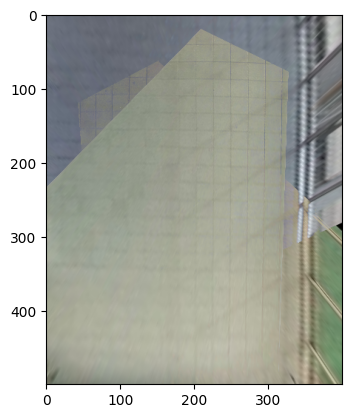

In [5]:
output_shape = (400, 500)
composite = np.zeros((output_shape[1], output_shape[0], 3), dtype=np.uint8)
for img, H in zip(base_images, homographies.values()):
    warped = cv2.warpPerspective(img, H, output_shape)
    composite = np.maximum(composite, warped)
plt.imshow(composite)

In [6]:
print(cam0data[200])

[('31', array([243.71818749,  16.03951778, 286.68809468, 137.04328881]))]


In [28]:
cam0_H = []
for frame in cam0data:
    h0frame = []
    for entry in frame:
        l, t, r, b = entry[1]
        diagonal = cv2.perspectiveTransform(np.array([[[l, b], [r, b]]]), homographies[0])[0]
        h0frame.append([entry[0], diagonal])
    cam0_H.append(h0frame)
cam1_H = []
for frame in cam1data:
    h1frame = []
    for entry in frame:
        l, t, r, b = entry[1]
        diagonal = cv2.perspectiveTransform(np.array([[[l, b], [r, b]]]), homographies[1])[0]
        h1frame.append([entry[0], diagonal])
    cam1_H.append(h1frame)
cam2_H = []
for frame in cam2data:
    h2frame = []
    for entry in frame:
        l, t, r, b = entry[1]
        diagonal = cv2.perspectiveTransform(np.array([[[l, b], [r, b]]]), homographies[2])[0]
        h2frame.append([entry[0], diagonal])
    cam2_H.append(h2frame)
cam3_H = []
for frame in cam3data:
    h3frame = []
    for entry in frame:
        l, t, r, b = entry[1]
        diagonal = cv2.perspectiveTransform(np.array([[[l, b], [r, b]]]), homographies[3])[0]
        h3frame.append([entry[0], diagonal])
    cam3_H.append(h3frame)
cams = [cam0_H, cam1_H, cam2_H, cam3_H]

In [23]:
import copy

def cosine_distance(vec1, vec2):
    n1 = np.linalg.norm(vec1)
    n2 = np.linalg.norm(vec2)
    if n1 == 0 or n2 == 0:
        return 1.0
    return np.dot(vec1, vec2) / (n1 * n2)

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def assoc_segments(views, prev_tracks, is_prev=True, thresh=0.5, cosweight=0.8, mweight=0.2, eweight=0.3):

    associations = []

    def single_pass(views, prev_tracks, associations, is_prev):
        longest_view = np.argmax(np.array([len(view) for view in views]))
        views_list = [i for i in range(len(views)) if i != longest_view]
        new_associations = []
        indices_to_delete = []
        for index, det in enumerate(views[longest_view]):
            group = copy.deepcopy([longest_view, det])
            trackid, segment = det
            segment_as_point = np.array([(segment[0, 0] + segment[1, 0]) / 2, (segment[0, 1] + segment[1, 1]) / 2])

            pf = []
            for item in prev_tracks[longest_view]:
                if item[0] == trackid:
                    pf = item[1]
            pf_as_point = np.array([(pf[0, 0] + pf[1, 0]) / 2, (pf[0, 1] + pf[1, 1]) / 2])
            for view in views_list:
                candidates = []
                for index2, det2 in enumerate(views[view]):
                    trackid2, segment2 = det2
                    segment2_as_point = np.array([(segment2[0, 0] + segment2[1, 0]) / 2, (segment2[0, 1] + segment2[1, 1]) / 2])

                    pf2 = []
                    for item in prev_tracks[view]:
                        if item[0] == trackid:
                            pf2 = item[1]
                    pf2_as_point = np.array([(pf2[0, 0] + pf2[1, 0]) / 2, (pf2[0, 1] + pf2[1, 1]) / 2])

                    motion_vector1 = segment_as_point - pf_as_point if is_prev else pf_as_point - segment_as_point
                    motion_vector2 = segment2_as_point - pf2_as_point if is_prev else segment2_as_point - pf2_as_point

                    cos_dist = 1 - np.abs(cosine_distance(motion_vector1, motion_vector2))
                    euclidean = 1 / (euclidean_distance(segment_as_point, segment2_as_point) + 1)
                    movement_diff = 1 / (np.abs(np.linalg.norm(segment_as_point - pf_as_point) - np.linalg.norm(segment2_as_point - pf2_as_point)) + 1)
                    score = cos_dist * cosweight + euclidean * eweight + movement_diff * mweight

                    if score >= thresh:
                        candidates.append((trackid, trackid2, score, index, index2))

                if candidates:
                    best_candidate = max(candidates, key=lambda x: x[2])
                    indices_to_delete.append(best_candidate[3])
                    del views[view][best_candidate[4]]
                    new_associations.append({view: best_candidate[0]})
                    group.append([view, det2])
            new_associations.append(group)
            associations.append(group)

        for index in sorted(indices_to_delete, reverse=True):
            del views[longest_view][index]
        
        return new_associations, views, associations

    max_iterations = len(views)
    for iteration in range(max_iterations):

        new_associations, views, associations = single_pass(views, prev_tracks, associations, is_prev)

        if len(new_associations) == 0:
            break

    for view in views:
        if len(view) != 0:
            for each in view:
                associations.append([view, [each]])

    return associations

In [24]:
def singlepass(views, pastviews, threshold, is_prev=True, cosweight=0.5, mweight=0.5, eweight=1.5, fallbackthreshold=0.3):
    longest_view_index = max(range(len(views)), key=lambda i: len(views[i]))
    longest_view = views[longest_view_index]

    associations = []

    for idx, det in enumerate(longest_view):
        trackid, segment = det
        segmentaspoint = np.array([(segment[0, 0] + segment[1, 0]) / 2, (segment[0, 1] + segment[1, 1]) / 2])

        pf = None
        
        for item in pastviews[longest_view_index]:
            if item[0] == trackid:
                pf = item[1]
                pfaspoint = np.array([(pf[0, 0] + pf[1, 0]) / 2, (pf[0, 1] + pf[1, 1]) / 2])

        if pf is None:
            

        newgroup = []

        newgroup.append([longest_view, trackid, segment])
        
        for vidx, view in enumerate(views):
            if vidx == longest_view_index:
                continue

            best_similarity = -float('inf')
            best_detection_idx = None

            for otheridx, otherdet in enumerate(view):
                trackid2, segment2 = otherdet
                segment2aspoint = np.array([(segment2[0, 0] + segment2[1, 0]) / 2, (segment2[0, 1] + segment2[1, 1]) / 2])

                for item in pastviews[vidx]:
                    if item[0] == trackid2:
                        pf2 = item[1]
                        pf2aspoint = np.array([(pf2[0, 0] + pf2[1, 0]) / 2, (pf2[0, 1] + pf2[1, 1]) / 2])

                motion_vector1 = segmentaspoint - pfaspoint if is_prev else pfaspoint - segmentaspoint
                motion_vector2 = segment2aspoint - pf2aspoint if is_prev else segment2aspoint - pf2aspoint

                print(f"Motion Vector 1: {motion_vector1}, Motion Vector 2: {motion_vector2}")

                #similarity could also be exp(-dist**2)
                
                cos_dist = (1 + cosine_distance(motion_vector1, motion_vector2)) / 2
                euclidean = 1 / (euclidean_distance(segmentaspoint, segment2aspoint) + 1)
                movement_diff = 1 / (np.abs(np.linalg.norm(segmentaspoint - pfaspoint) -
                                           np.linalg.norm(segment2aspoint - pf2aspoint)) + 1)
                score = cos_dist * cosweight + euclidean * eweight + movement_diff * mweight

                print(f"Detection {trackid2} in view {vidx}, Cosine Dist: {cos_dist}, Euclidean: {euclidean}, Movement Diff: {movement_diff}, Similarity Score: {score}")

                if score > best_similarity:
                    best_similarity = score
                    best_detection_idx = otheridx

            if best_similarity >= threshold and best_detection_idx is not None:
                newgroup.append(vidx, *view[best_detection_idx])

        if len(newgroup) > 0:
            associations.append(newgroup)

        print(f"New association group for Detection {trackid}: {newgroup}")

    return associations, views

In [ ]:
def full_pipeline(views, pastviews, threshold, max_iterations=None, is_prev=True, cosweight=0.5, mweight=0.5, eweight=1.5, fallbackthreshold=0.3):
    max_iterations = max_iterations or (len(views) - 1)
    all_associations = []
    iteration_count = 0

    while iteration_count < max_iterations:
        print(f"Iteration {iteration_count + 1}:")
        associations, updated_views = singlepass(
            views, pastviews, threshold, is_prev, cosweight, mweight, eweight, fallbackthreshold
        )
        
        all_associations.extend(associations)

        for group in associations:
            for view_idx, det in group:
                trackid, segment = det
                views[view_idx] = [v for v in views[view_idx] if v[0] != trackid]

        if all(len(view) == 0 for view in views):
            break

        if sum(len(view) > 0 for view in views) <= 1:
            break

        if not any(len(group) > 1 for group in associations): 
            break

        pastviews = [view[:] for view in updated_views]
        iteration_count += 1

    unmatched = [
        (vidx, det) for vidx, view in enumerate(views) for det in view
    ]
    for vidx, det in unmatched:
        all_associations.append([(vidx, det)])

    return all_associations

Motion Vector 1: [-1.76424432 -0.04061613], Motion Vector 2: [-0.50862313 -1.5004451 ]
Detection 31 in view 1, Cosine Dist: 0.3286248283561301, Euclidean: 0.009738404562124669, Movement Diff: 0.8471679912217652, Similarity Score: 0.43525498229789455
Motion Vector 1: [-1.76424432 -0.04061613], Motion Vector 2: [-0.15634271  0.74203846]
Detection 33 in view 1, Cosine Dist: 0.40820436499530155, Euclidean: 0.026305359012187734, Movement Diff: 0.49840958293534604, Similarity Score: 0.43413701628696677
Motion Vector 1: [-1.76424432 -0.04061613], Motion Vector 2: [-0.11069191 -0.10164897]
Detection 34 in view 1, Cosine Dist: 0.12403754003230927, Euclidean: 0.008996273259455121, Movement Diff: 0.38249284151933033, Similarity Score: 0.17842748230755
Motion Vector 1: [-1.76424432 -0.04061613], Motion Vector 2: [0.95064902 1.44921754]
Detection 31 in view 2, Cosine Dist: 0.7837972562150882, Euclidean: 0.005210609925200714, Movement Diff: 0.9694462058090397, Similarity Score: 0.8224902291114388
Mo